In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from potentials import barrier_potential

from matplotlib import rc # check need
from matplotlib.animation import FFMpegWriter # check need

In [2]:
l_x = 100
dx = 1e-3
dt = 1e-4
#V  = np.zeros(l_x)
V = barrier_potential(l_x)
#xs = np.arange(l_x)

In [3]:
def initial_wavepacket(xs, x0 = 0, k0 = 0, sigma = 10):
    """TODO: comment this bad boi"""
    def wavepacket(x):
        return np.exp(-(x-x0) * (4*1j*k0 + (x0 - x) * sigma**2)*np.sqrt(np.pi)*sigma) / np.sqrt(np.sqrt(2)*np.pi**(3/2) * sigma)
    
    return np.array([wavepacket(x) for x in xs])

In [4]:
psi_0 = initial_wavepacket(np.arange(l_x), x0 = l_x/2, k0 = 0.01, sigma = 0.07)
print (psi_0)

[5.96892075+1.51231772j 5.62726336+1.39607051j 5.31147783+1.28977869j
 5.01938188+1.19250156j 4.74899666+1.10339377j 4.49852641+1.02169498j
 4.26634034+0.94672083j 4.05095628+0.87785479j 3.85102623+0.81454101j
 3.66532325+0.75627791j 3.49272984+0.70261257j 3.33222745+0.6531356j
 3.1828871 +0.60747672j 3.04386091+0.56530071j 2.91437456+0.52630385j
 2.79372044+0.49021071j 2.68125154+0.45677134j 2.57637587+0.42575869j
 2.47855158+0.39696635j 2.38728234+0.37020648j 2.30211343+0.34530801j
 2.22262795+0.32211501j 2.14844364+0.30048516j 2.07920979+0.28028851j
 2.01460463+0.2614062j  1.95433283+0.24372946j 1.89812332+0.22715862j
 1.84572728+0.21160225j 1.79691635+0.19697634j 1.75148098+0.18320364j
 1.70922893+0.170213j   1.66998397+0.15793876j 1.63358463+0.14632028j
 1.5998831 +0.1353014j  1.56874426+0.12483008j 1.54004477+0.1148579j
 1.51367224+0.1053398j  1.48952452+0.09623369j 1.46750904+0.08750016j
 1.44754222+0.07910221j 1.42954894+0.07100497j 1.41346204+0.06317548j
 1.39922197+0.05558247

In [5]:
# tells us the sum of the probabilities
print(np.trapz(psi_0, dx=dx))

(0.24023718205455208+0.0014541941142262003j)


In [6]:
def separate_complex_components (cmplx):
    """
    takes an array of complex numbers and returns the array split into 
    its real, imaginary, and square magnitude components.

    Arguments
    ---------

        psi: numpy.complex array (num_positions)

    Returns
    -------
    
        real: float array (num_positions)

        imaginary: float array (num_positions)

        square_magnitude: float array (num_positions)

    returns (real, imaginary, square_magnitude)

    """
    return (np.real(cmplx), np.imag(cmplx), np.absolute(cmplx))

In [7]:
def tridiagonal_matrix(on_diag, off_diag):
    """Fills and returns a wrap-around tridiagonal matrix.
    
    Parameters
    ----------
    on_diag: array-like, shape of (l_x)
        Elements on the diagonal.
    
    off_diag : array-like, shape of (l_x)
        Elements off the diagonal.
    
    Returns
    -------
    M : array-like, shape of (l_x, l_x)
        Tridiagonal matrix with elements filled in.
    """
    l_x = len(on_diag)
    M = np.zeros((l_x, l_x), dtype='complex128')
    ind_j = np.arange(l_x)
    ind_i, ind_k = (ind_j-1)%l_x, (ind_j+1)%l_x
    M[(ind_j, ind_j)] = on_diag
    M[(ind_j, ind_k)] = off_diag
    M[(ind_j, ind_i)] = off_diag
    return M

In [8]:
def finite_diff(V, dx, dt):
    """Runs finite difference algorithm to compute the linear system to solve.
    
    Parameters
    ----------
    V : array-like, shape of (l_x)
        Potential at each location x.
    
    dx : float
        Increments of space to simulate at.
    
    dt : float
        Increments of time to simulate at.
    
    Returns
    -------
    M : array-like, shape of (2, l_x, l_x)
        Tridiagonal matrix representing the linear equations to solve.
        The first matrix is the LHS, and the second is the RHS (which is None).
    """
    l_x = V.shape[0]
    t_i = -dt/1j
    v_jj = [((1/dx)**2 + V[j] - 1j/dt)*t_i for j in range(l_x)]
    v_jk = (-1/(2*dx**2)*t_i) * np.ones(l_x)
    return [tridiagonal_matrix(v_jj, v_jk), None]

In [9]:
def crank_nicholson(V, dx, dt):
    """Runs Crank-Nicholson algorithm to compute the linear system to solve.
    
    Parameters
    ----------
    V : array-like, shape of (l_x)
        Potential at each location x.
    
    dx : float
        Increments of space to simulate at.
    
    dt : float
        Increments of time to simulate at.
    
    Returns
    -------
    M : array-like, shape of (2, l_x, l_x)
        Tridiagonal matrix representing the linear equations to solve.
        The first matrix is the LHS and the second is the RHS.
    """
    
    l_x = V.shape[0]
    t_i = dt*1j
    vl_jj = [1 + t_i/dx**2 + V[j]*t_i/2 for j in range(l_x)]
    vl_jk = (-t_i/(2*dx**2)) * np.ones(l_x)
    vr_jj = [1 - t_i/dx**2 - V[j]*t_i/2 for j in range(l_x)]
    vr_jk = (t_i/(2*dx**2)) * np.ones(l_x)
    return [tridiagonal_matrix(vl_jj, vl_jk), tridiagonal_matrix(vr_jj, vr_jk)]


In [10]:
def tdse_step(M, psi_0, method='CN'):
    """Runs one step of the Time-Dependent Schrodinger Equation (TDSE).
    
    Parameters
    ----------
    M : array-like, shape of (, l_x, l_x)
        LHS and RHS of linear system of equations to solve.
    
    psi_0 : array-like, shape of (l_x)
        Value of wave function at current time step, RHS of linear system.
    
    Returns
    -------
    psi_1 : array-like, shape of (l_x)
        Value of wave function at next time step, solution to the linear system.
    """
    psi = np.dot(M[1], psi_0) if method == 'CN' else psi_0
    return np.linalg.solve(M[0], psi)


def plot_psi(psi, title):
    """Plots a single value of the wave function.
    
    Parameters
    ----------
    psi: array-like, shape of (l_x)
        Wave function.
    
    Returns
    -------
    fig, ax: Matplotlib object
        Plot of the real and imaginary parts.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_title(title)
    ax.plot(range(len(psi)), psi.real, label='Real')
    ax.plot(range(len(psi)), psi.imag, label='Imaginary')
    ax.plot(range(len(psi)), np.abs(psi), label='Magnitude')
    ax.legend(loc='upper right')
    return fig, ax



In [11]:
def animate_psi(fig, ax, 
                psi, potential, dt, dx, repeat=True, repeat_delay=1000, 
                slowdown = 5,
                real_vis = {'color': 'firebrick', 'alpha':'0.5'},
                imag_vis = {'color': 'gold',      'alpha':'0.5'},
                smag_vis = {'color': 'slategrey', 'alpha':'0.5'}):
    """ 

    Arguments
    ---------
        psi: array-like (num_frames, num_positions) 

        potential: array-like ()

        dt: float
            the time simulated between the arrays of complex numbers in 

        dx: float 
            physical distance between the complex numbers in the internal 
            arrays of complex number in psi

        repeat: bool
            true if the 
                
        repeat_delay: float
            the delay in milliseconds before repeating the animation 
                  should repeat be set to true.

    Returns
    -------

        None

    """


    num_frames, num_positions = np.shape(psi)

    # set axes boundaries
    ax.set_ylim(-20,20)
    #ax.set_ylim(-2,2)
    ax.set_xlim(0,(num_positions-1)*dx)

    ## TODO clean up    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='red', alpha=0.5)

    # place a text box in upper left in axes coords
    time_display = ax.text(0.05, 0.95, 's', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ## TODO clean up    
    
    # setup some garbage
    x = np.linspace(0,(num_positions-1)*dx, num_positions)

    potential_line, = ax.plot(x, potential, linewidth = 10)

    def next_arrays_to_visualize (i): 
        rl, im, mag = separate_complex_components(psi[i])
        return rl, im, np.square(mag)

    def init(): return animate(0)
    
    def animate(i):
        ax.collections.clear()
        real, imag, smag = next_arrays_to_visualize(i)
        real_area = ax.fill_between  (x, real, **real_vis)
        imag_area = ax.fill_between  (x, imag, **imag_vis)
        smag_area = ax.fill_between  (x, smag, **smag_vis)
        time_display.set_text('time: {}'.format(np.round(dt*i,3)))
        return (real_area, imag_area, smag_area, time_display)

    
    # call the animator. blit=True means only re-draw the parts that have changed.
        
    return animation.FuncAnimation(fig, animate, frames=num_frames, 
            init_func=init, interval=(dt*1000)*slowdown, blit=True)
            #repeat_delay=repeat_delay, repeat=repeat, save_count=50)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x278ac3031d0>)

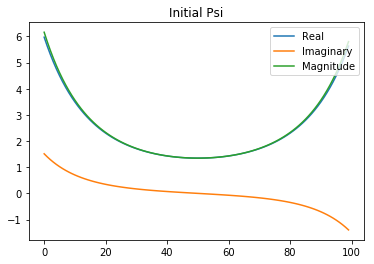

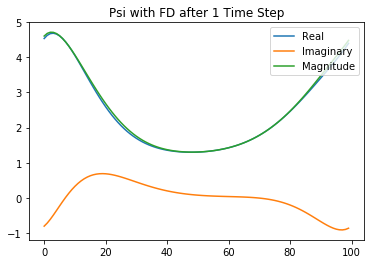

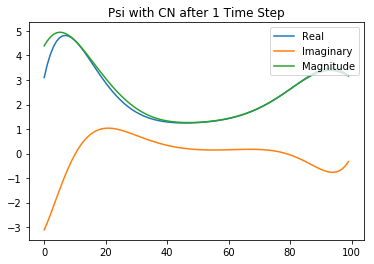

In [12]:
M_FD = finite_diff(V, dx, dt)
M_CN = crank_nicholson(V, dx, dt)
psi_fd = tdse_step(M_FD, psi_0, method='FD')
psi_cn = tdse_step(M_CN, psi_0, method='CN')
plot_psi(psi_0, title='Initial Psi')
plot_psi(psi_fd, title='Psi with FD after 1 Time Step')
plot_psi(psi_cn, title='Psi with CN after 1 Time Step')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x278ac416390>)

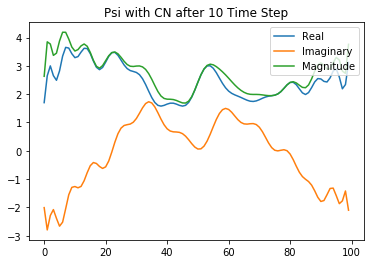

In [13]:
result = [psi_0]
for i in range (0, 100):
    result.append(tdse_step(M_CN, result[-1], method='CN'))

plot_psi(result[-1], title='Psi with CN after 10 Time Step')
    


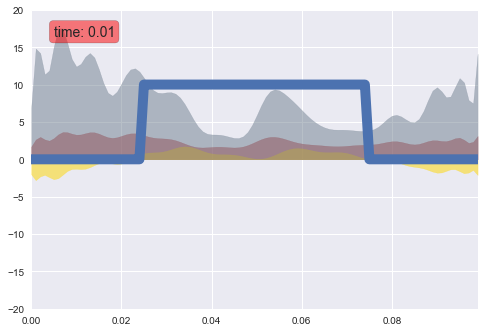

In [14]:
# Turn interactive plotting off
plt.ioff()

# setup plotstyle 
plt.style.use('seaborn')

# create animation
fig, ax = plt.subplots()
ani = animate_psi(fig, ax, result, V, dt, dx, slowdown=1000)
HTML(ani.to_jshtml())